# INF-616 - Tarefa 4 - TF-IDF, seleção de características e redução de dimensionalidade

Professor: Jacques Wainer -- wainer@ic.unicamp.br  
Monitor: Lucas David -- ra188972@students.ic.unicamp.br

Alunos: Carlos Eduardo Fernandes e Yakov Nae
        
Instituto de Computação - Unicamp  
2018

In [1]:
import itertools

import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from IPython.display import display, HTML

from __future__ import print_function

pd.set_option('display.max_colwidth', -1)

%matplotlib inline

np.random.seed(9510)

In [2]:
# Algumas funções que podem ser úteis mais a frente:

def describe(x, y, classes):
    """Descreve um conjunto de dados.
    
    :param x: np.ndarray, as amostras no conjunto.
    :param y: np.ndarray, os rotulos associados as amostras `x`.
    :param classes: list, uma lista com os nomes de cada classe. 
    """
    samples, features = (len(x), len(x[0])) if isinstance(x, list) else x.shape

    _, counts = np.unique(y, return_counts=True)
    print('  frequência das classes:',
          *('    %s: %i' % e for e in zip(classes, counts)),
          sep='\n')

def show_datasets(x, y, classes, title):
    """Encontra um "embedding" de um conjunto que alinha as direções
       de maximiza separação das amostras com os eixos da base canônica,
       permitindo uma melhor vizualização do conjunto.
    
    :param x: np.ndarray, as amostras do conjunto.
    :param y: np.ndarray, os rotulos associados as amostras `x`.
    :param title: str, o titulo do conjunto a ser exibido.
    """
    x = TruncatedSVD(n_components=2).fit_transform(x)
    
    plt.figure(figsize=(12, 6))
    for c in np.unique(y):
        s = y == c
        plt.scatter(x[s][:, 0], x[s][:, 1], label=classes[c])
    plt.legend()
    plt.title(title)
    plt.axis('off')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    width = max(6, len(classes))
    plt.figure(figsize=(width, width // 2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

def train_and_report(grid, train, test, classes):
    if not isinstance(grid, GridSearchCV):
        raise ValueError('Você deve passar um objeto da classe `GridSearchCV` '
                         'à função `train_and_report`. Ajuste seu modelo e sua '
                         'chamada apropriadamente.')
    grid.fit(*train)
    print('Melhores parâmetros:', grid.best_params_)
    print('Melhor pontuação sobre validação:', grid.best_score_)
    
    print('Resultados sobre a validação cruzada:')
    properties = ['params',
                  'mean_fit_time',
                  'rank_test_score',
                  'mean_test_score']
    display(pd.DataFrame({p: grid.cv_results_[p] for p in properties})
              .set_index('rank_test_score')
              .sort_index())

    print('Resultados sobre o teste:')
    p = grid.predict(test[0])
    print(metrics.classification_report(test[1], p))
    plot_confusion_matrix(metrics.confusion_matrix(test[1], p), classes,
                          normalize=True)
    return p

## Introdução ao 20 News Groups

In [3]:
# O codigo abaixo ira baixar e carregar o conjunto `20newsgroups`.
# Leia sobre este conjunto aqui: http://scikit-learn.org/stable/datasets/twenty_newsgroups.html

train, test = (datasets.fetch_20newsgroups(subset=subset, remove=('headers', 'footers', 'quotes'), shuffle=True)
               for subset in ('train', 'test'))

print('Algumas amostras em 20 News Groups:')
samples_to_show = 10
display(pd.DataFrame({'article': [a[320:370] for a in train.data[:samples_to_show]],
                      'label': np.asarray(train.target_names)[train.target[:samples_to_show]]}))

print('Conjunto 20 News Groups treino:')
describe(train.data, train.target, train.target_names)

Algumas amostras em 20 News Groups:


,article,label
0,"ellme a model name, engine specs, years\nof product",rec.autos
1,0 and 1.4 m floppies are especially requested.\n\nI,comp.sys.mac.hardware
2,does anybody know any dirt on when the next round,comp.sys.mac.hardware
3,,comp.graphics
4,"the code\nand possibly introduce new bugs, they ju",sci.space
5,irst point evidently was to show that not all weap,talk.politics.guns
6,"g to delete a file last September. ""Hmmm... 'News?",sci.med
7,"ASE in SPEED, the Mac Quadra uses this version of",comp.sys.ibm.pc.hardware
8,,comp.os.ms-windows.misc
9,"blems with file icons being lost, but it's\nhard to",comp.sys.mac.hardware


Conjunto 20 News Groups treino:
  frequência das classes:
    alt.atheism: 480
    comp.graphics: 584
    comp.os.ms-windows.misc: 591
    comp.sys.ibm.pc.hardware: 590
    comp.sys.mac.hardware: 578
    comp.windows.x: 593
    misc.forsale: 585
    rec.autos: 594
    rec.motorcycles: 598
    rec.sport.baseball: 597
    rec.sport.hockey: 600
    sci.crypt: 595
    sci.electronics: 591
    sci.med: 594
    sci.space: 593
    soc.religion.christian: 599
    talk.politics.guns: 546
    talk.politics.mideast: 564
    talk.politics.misc: 465
    talk.religion.misc: 377


**Vamos binarizar o problema:**

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.classes_ = train.target_names

computing_classes, rec_classes = ([t for t in train.target_names if tag in t]
                                   for tag in ('comp.', 'soc.religion.'))
computing_codes, rec_codes = (le.transform(t)
                              for t in (computing_classes, rec_classes))

binary_set = []

for (data, target) in ((train.data, train.target), (test.data, test.target)):
    computing_samples = np.in1d(target, computing_codes)
    rec_samples = np.in1d(target, rec_codes)
    
    x0 = [tx for tx, selected in zip(data, computing_samples) if selected]
    x1 = [tx for tx, selected in zip(data, rec_samples) if selected]
    
    binary_set += [(x0 + x1, np.concatenate((np.zeros(len(x0)), np.ones(len(x1)))))]

(x_train, y_train), (x_test, y_test) = binary_set
target_names = ['computação', 'religião']

In [5]:
print((y_train == 0).sum(), 'artigos relacionadas à computação')
print((y_train == 1).sum(), 'artigos relacionados à religião')

2936 artigos relacionadas à computação
599 artigos relacionados à religião


## Processando texto com o TF-IDF

1. **Vetorize as amostras de texto em *20newgroups* em um conjunto de características utilizando o TF-IDF. Utilize as palavras de parada da lingua inglesa.**

2. **Em seguida, remova todas as features que não possuam uma variância maior ou igual à $t = 1e^{-4}$.**

3. **Finalmente, treine um classificador `LogisticRegression` buscando por valores de `C` no intervalo *(100, 10,000)***

Dica: use o parâmetro `verbose=2` quando iniciar o grid-search. Isso lhe dará uma ideia do progresso da busca, caso ela tome muito tempo.

Bônus: tente executar todas ações de uma única vez, utilizando a classe `Pipeline`!

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__C=166.8, var_filter__threshold=0.0001 ......................
[CV] clf__C=166.8, var_filter__threshold=0.0001 ......................
[CV] clf__C=166.8, var_filter__threshold=0.0001 ......................
[CV] ....... clf__C=166.8, var_filter__threshold=0.0001, total=   7.3s
[CV] ....... clf__C=166.8, var_filter__threshold=0.0001, total=   7.6s
[CV] ....... clf__C=166.8, var_filter__threshold=0.0001, total=   7.4s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.5s finished


Melhores parâmetros: {'clf__C': 166.8, 'var_filter__threshold': 0.0001}
Melhor pontuação sobre validação: 0.6241824288492134
Resultados sobre a validação cruzada:


,params,mean_fit_time,mean_test_score
rank_test_score,,,
1,"{'clf__C': 166.8, 'var_filter__threshold': 0.0001}",6.530251,0.624182


Resultados sobre o teste:
             precision    recall  f1-score   support

          0       0.40      0.37      0.38       319
          1       0.52      0.58      0.55       389
          2       0.54      0.51      0.52       394
          3       0.55      0.55      0.55       392
          4       0.66      0.56      0.61       385
          5       0.67      0.58      0.62       395
          6       0.68      0.73      0.70       390
          7       0.57      0.58      0.57       396
          8       0.68      0.65      0.67       398
          9       0.44      0.69      0.53       397
         10       0.81      0.75      0.78       399
         11       0.72      0.63      0.67       396
         12       0.41      0.42      0.42       393
         13       0.60      0.57      0.59       396
         14       0.62      0.61      0.62       394
         15       0.54      0.60      0.57       398
         16       0.46      0.46      0.46       364
         17       0

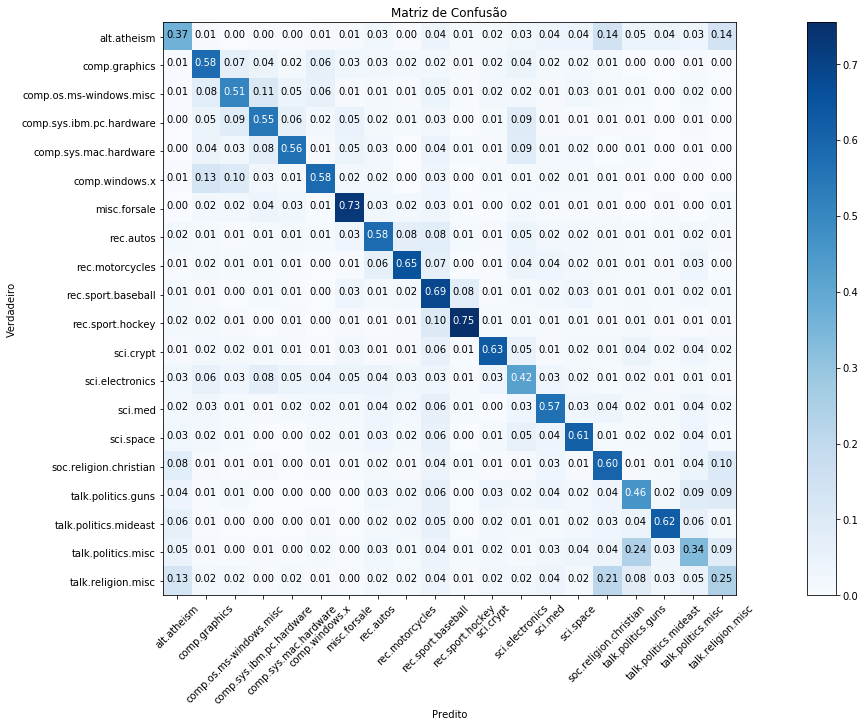

In [22]:
# from sklearn... import ...
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
   
my_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer( stop_words='english' )),
#    ('tfidf', TfidfVectorizer()),
    ('var_filter', VarianceThreshold()),
    ('clf', LogisticRegression())
])
params = {
#    'tfidf__stop_words': ('english'),
    'var_filter__threshold': [1/10000],
    'clf__C': np.logspace(2, 4, 10) #10 numbers from 10^2 to 10^4
}
grid = GridSearchCV(my_pipeline, params, n_jobs=3, verbose=2)
# params = {...}
# model = ...
# grid = ...
p_LR=train_and_report(grid,
##                 test=(x_train, y_train),
#                 train=(x_train, y_train),
#                 test=(x_test, y_test),
#                 classes=target_names)
                 train=(train.data, train.target),
                 test=(test.data, test.target),
                 classes=train.target_names)

**Reporte a ROC AUC sobre o conjunto de teste.**

In [23]:
# print('ROC AUC:', ...)
#roc_LR = metrics.roc_auc_score(p_LR, y_test)
#print('ROC:', roc_LR)

ValueError: multiclass format is not supported

### Visualizando o conjunto após a transformação

In [15]:
# Resgata o modelo com os parâmetros de melhor pontuação sobre as
# dobras de validação, retreinado sobre todo o conjunto de treino.
model = grid.best_estimator_

**Você usou o pipeline no passo anterior?**

In [16]:
pipeline_used = True  # altere aqui se necessário

if pipeline_used:
    transformers = model.steps[:2]
else:
    tfidf = None # substitua por seu transformador TF-IDF.
    vt = None # substitua por seu seletor de features baseado em variância.
    transformers = [
        ('tfidfvectorizer', tfidf),
        ('variancethreshold', vt),
    ]

In [17]:
from sklearn.pipeline import Pipeline

# Cria um novo pipeline com o TF-IDF e o seletor de características.
transformer = Pipeline(transformers)
t_train = transformer.transform(x_train)

print('Número de características após transformação TF-IDF:',
transformer.named_steps['tfidf'].transform(x_train).shape[1])
print('Número de características após seleção de características:', t_train.shape[1])

Número de características após transformação TF-IDF: 58816
Número de características após seleção de características: 2221


In [18]:
print('Estatísticas sobre a variância das características antes e após a seleção:')

vt = transformer.named_steps['var_filter']
chosen_features = vt.get_support()

var_stats = pd.concat((pd.Series(vt.variances_).describe(),
                       pd.Series(vt.variances_[chosen_features]).describe()),
                      axis=1)
var_stats.columns = ['original', 'selected']
display(var_stats.T)

Estatísticas sobre a variância das características antes e após a seleção:


,count,mean,std,min,25%,50%,75%,max
original,58816.0,0.000016,0.000069,4.127196e-12,1.924400e-08,4.057087e-08,0.000007,0.002788
selected,2221.0,0.000261,0.000240,1.000166e-04,1.304363e-04,1.795265e-04,0.000289,0.002788


**Exibindo um *embedding* para o conjunto:**

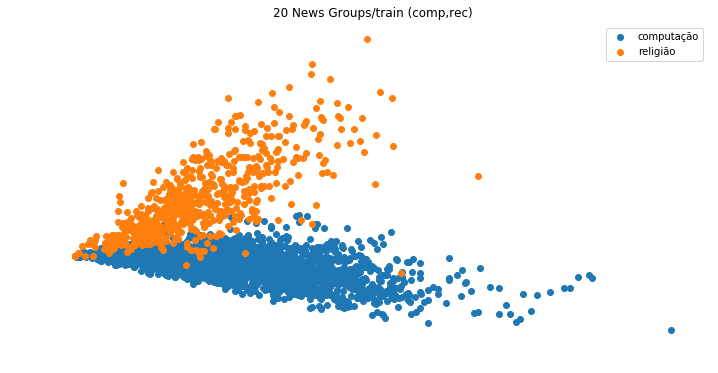

In [19]:
show_datasets(t_train, y_train.astype(int),
              target_names,
              title='20 News Groups/train (comp,rec)')

## Redução de dimensionalidade

1. **Utilize o `Non-Negative Matrix Factorization (NMF)` para reduzir a dimensionalidade do conjunto 20 news groups binarizado e vetorizado (mas não reduzido com a seleção de características) acima.**
2. **Utilize um classificador baseado no algoritmo Random Forest, buscando pelo número de árvores no intervalo *(100, 500)*.**

Dica: use um `GridSearchCV#n_jobs` pequeno aqui.

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__n_estimators=100 ...........................................
[CV] ............................ clf__n_estimators=100, total=  11.3s
[CV] clf__n_estimators=100 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s


[CV] ............................ clf__n_estimators=100, total=  10.5s
[CV] clf__n_estimators=100 ...........................................
[CV] ............................ clf__n_estimators=100, total=  10.7s
[CV] clf__n_estimators=200 ...........................................
[CV] ............................ clf__n_estimators=200, total=  11.4s
[CV] clf__n_estimators=200 ...........................................
[CV] ............................ clf__n_estimators=200, total=  14.0s
[CV] clf__n_estimators=200 ...........................................
[CV] ............................ clf__n_estimators=200, total=  14.9s
[CV] clf__n_estimators=300 ...........................................
[CV] ............................ clf__n_estimators=300, total=  12.2s
[CV] clf__n_estimators=300 ...........................................
[CV] ............................ clf__n_estimators=300, total=  11.9s
[CV] clf__n_estimators=300 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.3min finished


Melhores parâmetros: {'clf__n_estimators': 200}
Melhor pontuação sobre validação: 0.977086280056577
Resultados sobre a validação cruzada:


,params,mean_fit_time,mean_test_score
rank_test_score,,,
1,{'clf__n_estimators': 200},13.149222,0.977086
2,{'clf__n_estimators': 400},11.862679,0.976521
3,{'clf__n_estimators': 100},10.574391,0.976238
4,{'clf__n_estimators': 300},12.451479,0.975955
4,{'clf__n_estimators': 500},12.602687,0.975955


Resultados sobre o teste:
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      1955
        1.0       0.95      0.85      0.90       398

avg / total       0.97      0.97      0.97      2353



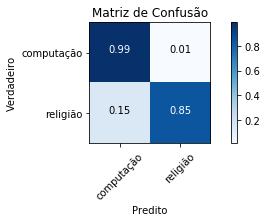

In [20]:
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier

my_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer( stop_words='english' )),
    ('nmf', NMF(n_components=20, init='random', random_state=0)),
    ('clf', RandomForestClassifier(min_samples_split=3))
])
params = {
    'clf__n_estimators': [100,200,300,400,500]
}
grid = GridSearchCV(my_pipeline, params, n_jobs=1, verbose=2)

# params = ...
# model = ...
# grid = ...
p_RF=train_and_report(grid,
#                 train=(x_train, y_train),
#                 test=(x_test, y_test),
#                 classes=target_names)
                 train=(train.data, train.target),
                 test=(test.data, test.target),
                 classes=train.target_names)

**Reporte a ROC AUC sobre o conjunto de teste:**

In [21]:
# print('ROC AUC:', ...)
roc_RF = metrics.roc_auc_score(p_RF, y_test)
print('ROC:', roc_RF)

ROC: 0.9593826220586784


**Qual dos dois conjuntos de algoritmos apresentou o melhor resultado?**

In [ ]:
# ...

**Verifique se combater o desbalanceamento das classes em treino ao ponderar as amostras pelo inverso das frequências de suas classes (utilizando o parâmetro `class_weight='balanced'`) melhora os resultados:**

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__n_estimators=100 ...........................................
[CV] ............................ clf__n_estimators=100, total=  11.5s
[CV] clf__n_estimators=100 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s


[CV] ............................ clf__n_estimators=100, total=  10.9s
[CV] clf__n_estimators=100 ...........................................
[CV] ............................ clf__n_estimators=100, total=  12.4s
[CV] clf__n_estimators=200 ...........................................
[CV] ............................ clf__n_estimators=200, total=  12.7s
[CV] clf__n_estimators=200 ...........................................
[CV] ............................ clf__n_estimators=200, total=  12.2s
[CV] clf__n_estimators=200 ...........................................
[CV] ............................ clf__n_estimators=200, total=  12.1s
[CV] clf__n_estimators=300 ...........................................
[CV] ............................ clf__n_estimators=300, total=  13.0s
[CV] clf__n_estimators=300 ...........................................
[CV] ............................ clf__n_estimators=300, total=  11.9s
[CV] clf__n_estimators=300 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.2min finished


Melhores parâmetros: {'clf__n_estimators': 300}
Melhor pontuação sobre validação: 0.9756718528995757
Resultados sobre a validação cruzada:


,params,mean_fit_time,mean_test_score
rank_test_score,,,
1,{'clf__n_estimators': 300},12.309759,0.975672
2,{'clf__n_estimators': 200},12.021036,0.975389
3,{'clf__n_estimators': 100},11.301857,0.975106
3,{'clf__n_estimators': 400},11.772381,0.975106
3,{'clf__n_estimators': 500},12.721542,0.975106


Resultados sobre o teste:
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      1955
        1.0       0.95      0.85      0.90       398

avg / total       0.97      0.97      0.97      2353



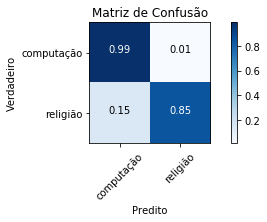

In [112]:
# params = ...
# model = ...
# grid = ...
my_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer( stop_words='english' )),
    ('nmf', NMF(n_components=20, init='random', random_state=0)),
    ('clf', RandomForestClassifier(class_weight='balanced',min_samples_split=3))
])
params = {
    'clf__n_estimators': [100,200,300,400,500]
}
grid = GridSearchCV(my_pipeline, params, n_jobs=1, verbose=2)
p_RFB=train_and_report(grid,
#                 train=(x_train, y_train),
#                 test=(x_test, y_test),
#                 classes=target_names)
                 train=(train.data, train.target),
                 test=(test.data, test.target),
                 classes=train.target_names)
roc_RFB = metrics.roc_auc_score(p_RFB, y_test)
print('ROC:', roc_RFB)